In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

molecule = Molecule(
    species=["C", "C", "H", "H", "H", "H"],
    positions=[
        [ 0.00000,       0.00000,        0.00000],
        [ distance_CC  ,       0.00000,        0.00000],
        [ distance_CH * np.cos(angle_HCC), distance_CH * np.sin(angle_HCC), 0.00000],
        [ distance_CH * np.cos(2*np.pi - angle_HCC), distance_CH * np.sin(2*np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(np.pi - angle_HCC), distance_CH * np.sin(np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(- np.pi + angle_HCC), distance_CH * np.sin(- np.pi + angle_HCC), 0.00000]
    ]
)

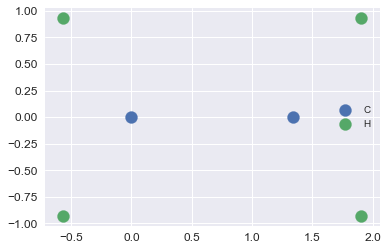

In [3]:
pos = np.array(molecule.positions)
plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")
plt.legend()

In [4]:
mol = molecule.get_pyscf_molecule()

mol.basis = "6-311++g**"

mol.build()

# Matrices 

In [5]:
from SCFInitialGuess.utilities.dataset import fock_from_density
from pyscf.scf import hf

mf = hf.RHF(mol)
mf.verbose = 1
mf.run()

if mf.iterations == mf.max_cycle:
    raise AssertionError("Sample could not be converged!")

h = mf.get_hcore(mol)
s = mf.get_ovlp()
p = mf.make_rdm1()
f = fock_from_density(p, s, h, mol)

# Utilities

In [6]:
import matplotlib as mpl
mpl.style.use(["seaborn", "thesis"])
ticker = mpl.ticker

In [7]:
z_value = 3
nx = 100
ny = 100

norm = None



In [8]:
from SCFInitialGuess.utilities.analysis import density_cut

# Guesses And Plots 

## Converged 

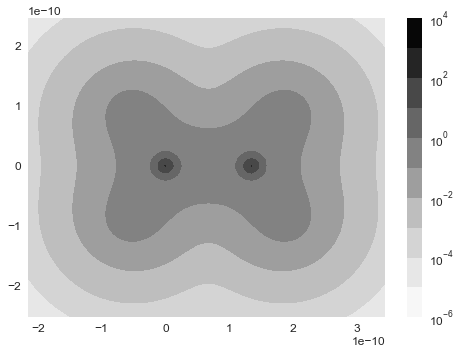

In [9]:
dm_density_converged, x, y = density_cut(mol, p, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density_converged, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

## SAD

In [10]:
p_sad = hf.init_guess_by_atom(mol)

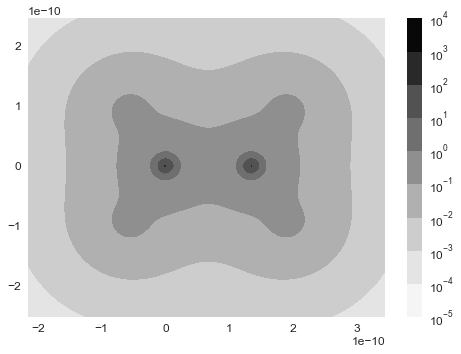

In [11]:
dm_density, x, y = density_cut(mol, p_sad, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

### Diff 

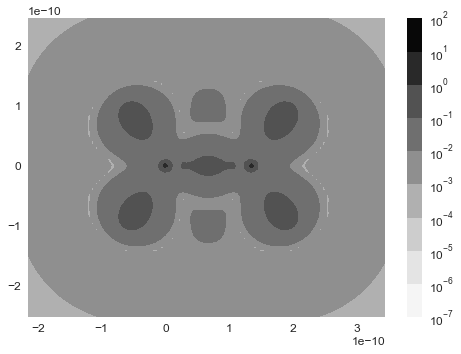

In [12]:
plt.contourf(*np.meshgrid(x, y), np.abs(dm_density - dm_density_converged), locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# GWH 

In [13]:
from SCFInitialGuess.construction.fock import gwh_scheme
from SCFInitialGuess.utilities.dataset import density_from_fock

f_gwh = gwh_scheme(np.diag(h), s)
p_gwh = density_from_fock(f_gwh, s, mol)

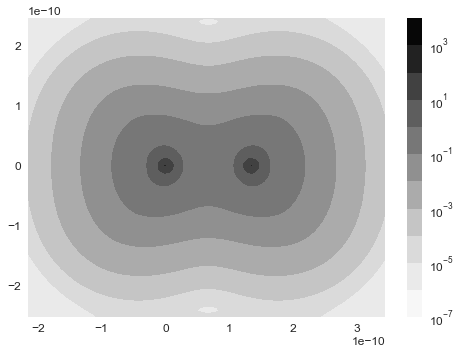

In [14]:
dm_density, x, y = density_cut(mol, p_gwh, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

### Diff

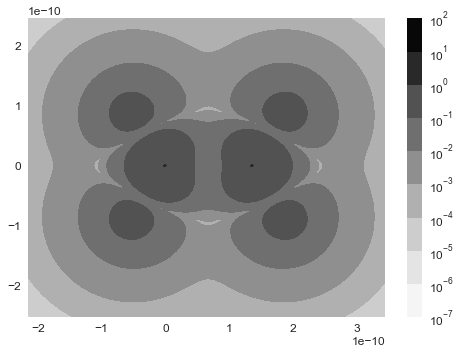

In [15]:
plt.contourf(*np.meshgrid(x, y), np.abs(dm_density - dm_density_converged), locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# E-GWH 

In [16]:
f_egwh = gwh_scheme(np.diag(f), s)
p_egwh = density_from_fock(f_egwh, s, mol)

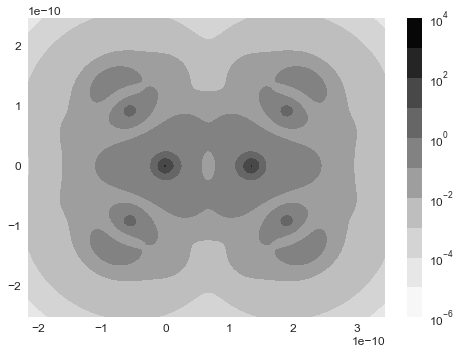

In [17]:
dm_density, x, y = density_cut(mol, p_egwh, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

### DIff

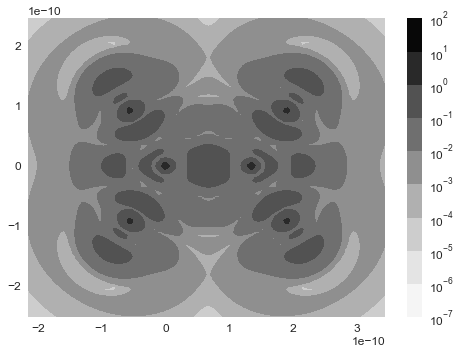

In [18]:
plt.contourf(*np.meshgrid(x, y), np.abs(dm_density - dm_density_converged), locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# E-GWH+ 

In [19]:
from SCFInitialGuess.construction.utilities import make_center_mask

mask_center = make_center_mask(molecule)

In [20]:
from SCFInitialGuess.construction.utilities import embed

f_egwh_plus = embed(f_egwh, f, mask_center)
p_egwh_plus = density_from_fock(f_egwh_plus, s, mol)

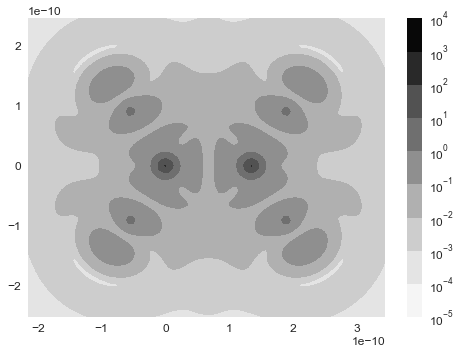

In [21]:
dm_density, x, y = density_cut(mol, p_egwh_plus, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# Embedded GWH 

In [22]:
f_embedded_gwh = embed(f_gwh, f, mask_center)
p_embedded_gwh = density_from_fock(f_embedded_gwh, s, mol)

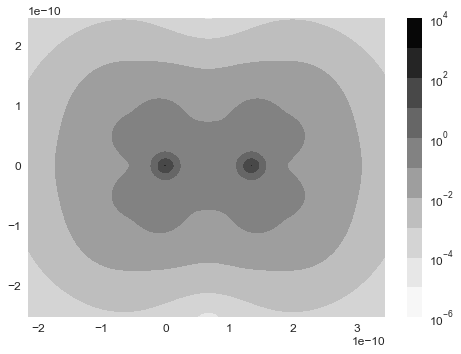

In [23]:
dm_density, x, y = density_cut(mol, p_embedded_gwh, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

### Diff 

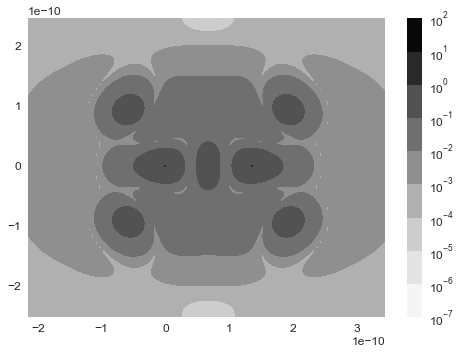

In [24]:
plt.contourf(*np.meshgrid(x, y), np.abs(dm_density - dm_density_converged), locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# SANND Center 

In [25]:
p_sannd_center = embed(p_gwh, p, mask_center)

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


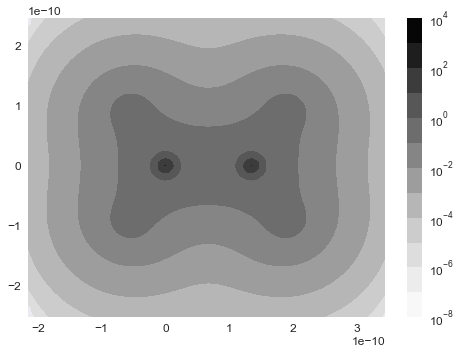

In [26]:
dm_density, x, y = density_cut(mol, p_sannd_center, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

### Diff 

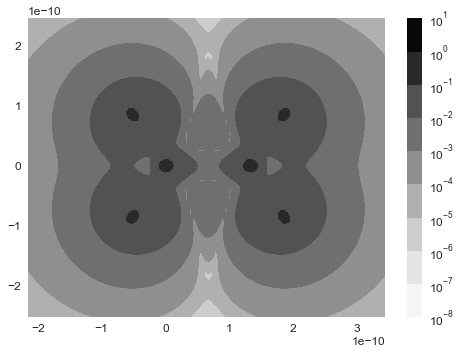

In [27]:
plt.contourf(*np.meshgrid(x, y), np.abs(dm_density - dm_density_converged), locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# SANND HOMO 

In [28]:
from SCFInitialGuess.construction.utilities import make_homo_mask

mask_homo = make_homo_mask(molecule)

In [36]:
p_sannd_homo = embed(p_sannd_center.copy(), p, mask_homo)

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


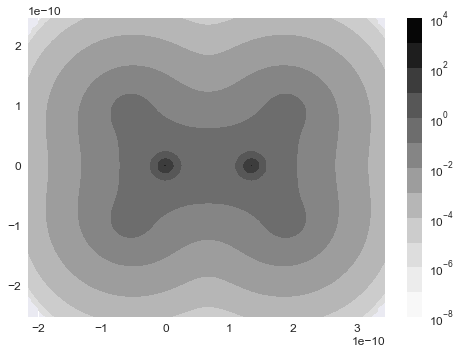

In [37]:
dm_density, x, y = density_cut(mol, p_sannd_homo, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

### Diff 

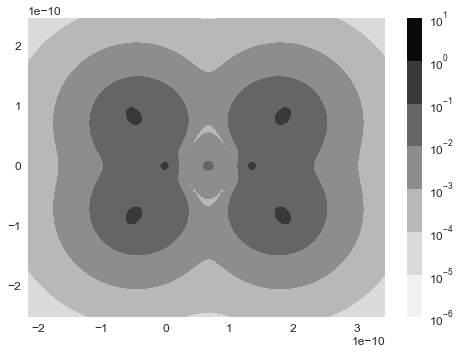

In [38]:
plt.contourf(*np.meshgrid(x, y), np.abs(dm_density - dm_density_converged), locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# SANND HETERO 

In [39]:
from SCFInitialGuess.construction.utilities import make_hetero_mask

mask_hetero = make_hetero_mask(molecule)

In [40]:
p_sannd_hetero = embed(p_sannd_center.copy(), p, mask_hetero)

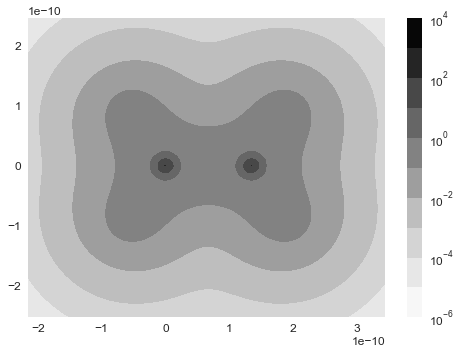

In [41]:
dm_density, x, y = density_cut(mol, p_sannd_hetero, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

### Diff 

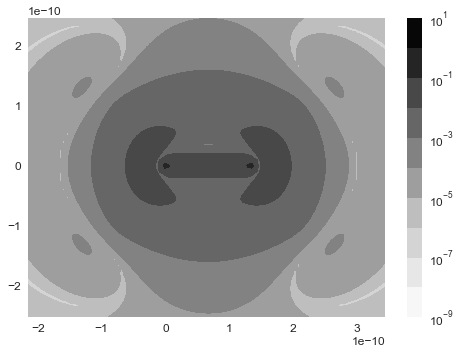

In [42]:
plt.contourf(*np.meshgrid(x, y), np.abs(dm_density - dm_density_converged), locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()